<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам
*Этот Ноутбук является Примером/Шаблоном (Baseline) к этому соревнованию и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.


> **baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline является хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

Помним, что по условию соревнования, нам нужно самостоятельно собрать обучающий датасет. В этом ноутбуке мы не будем рассматривать сбор данных. Предположим, что мы уже все собрали и просто подключили свой датасет через "Add Data", чтобы приступить к самому ML.

In [336]:
import numpy as np 
import pandas as pd 
import re
import sys
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')


In [337]:
from bs4 import BeautifulSoup
import requests as rs
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import chain
import json
import time

from scipy.stats import ttest_ind
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
from tqdm import tqdm
import warnings

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.base import clone

import requests  
from bs4 import BeautifulSoup as bs

In [338]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.2


In [339]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [340]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [341]:
# Функция нашей метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# Setup

In [342]:
VERSION    = 16
DIR_TRAIN  = '../parsing-all-moscow-auto-ru-09-09-2020/' # подключил к ноутбуку внешний датасет
DIR_TEST   = '../sf-dst-car-price-prediction/'
DIR_CARS = '../cars-df/'
VAL_SIZE   = 0.20   # 20%

In [343]:
DIR_TRAIN

'../parsing-all-moscow-auto-ru-09-09-2020/'

# Data

In [344]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [345]:
train = pd.read_csv("all_auto_ru_09_09_2020.csv.zip") # датасет для обучения модели
test = pd.read_csv('test.csv.zip')
cars_train = pd.read_csv('cars_df.csv.zip')
sample_submission = pd.read_csv('sample_submission.csv')

In [346]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [347]:
train.describe

<bound method NDFrame.describe of               bodyType       brand   color fuelType  modelDate  \
0                Седан        AUDI  040001   бензин     1990.0   
1                Седан        AUDI  EE1D19   бензин     1982.0   
2      Универсал 5 дв.        AUDI  0000CC   бензин     1988.0   
3                Седан        AUDI  CACECB   бензин     1988.0   
4                Седан        AUDI  040001   бензин     1990.0   
...                ...         ...     ...      ...        ...   
89373          Минивэн  SSANG_YONG  040001   дизель     2004.0   
89374          Минивэн  SSANG_YONG  CACECB   дизель     2004.0   
89375          Минивэн  SSANG_YONG  040001   дизель     2013.0   
89376          Минивэн  SSANG_YONG  97948F   дизель     2013.0   
89377          Минивэн  SSANG_YONG  FAFBFB   дизель     2013.0   

                         name  numberOfDoors  productionDate  \
0       2.8 MT (174 л.с.) 4WD            4.0            1991   
1            1.8 MT (90 л.с.)            4.0 

In [348]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [349]:
test.describe

<bound method NDFrame.describe of                 bodyType  brand  \
0                лифтбек  SKODA   
1                лифтбек  SKODA   
2                лифтбек  SKODA   
3                лифтбек  SKODA   
4                лифтбек  SKODA   
...                  ...    ...   
34681              седан    BMW   
34682              седан    BMW   
34683              седан    BMW   
34684  внедорожник 5 дв.    BMW   
34685  внедорожник 5 дв.    BMW   

                                                 car_url       color  \
0      https://auto.ru/cars/used/sale/skoda/octavia/1...       синий   
1      https://auto.ru/cars/used/sale/skoda/octavia/1...      чёрный   
2      https://auto.ru/cars/used/sale/skoda/superb/11...       серый   
3      https://auto.ru/cars/used/sale/skoda/octavia/1...  коричневый   
4      https://auto.ru/cars/used/sale/skoda/octavia/1...       белый   
...                                                  ...         ...   
34681  https://auto.ru/cars/used/sale/bmw

In [350]:
cars_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37181 entries, 0 to 37180
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              37181 non-null  object 
 1   brand                 37181 non-null  object 
 2   car_url               37181 non-null  object 
 3   color                 37181 non-null  object 
 4   description           37181 non-null  object 
 5   engineDisplacement    37181 non-null  object 
 6   enginePower           37181 non-null  object 
 7   fuelType              37181 non-null  object 
 8   image                 37181 non-null  object 
 9   mileage               37181 non-null  object 
 10  modelDate             37181 non-null  float64
 11  model_name            37181 non-null  object 
 12  name                  37181 non-null  object 
 13  numberOfDoors         37181 non-null  float64
 14  priceCurrency         37181 non-null  object 
 15  productionDate     

In [351]:
cars_train.describe

<bound method NDFrame.describe of                 bodyType     brand  \
0                минивэн  MERCEDES   
1      внедорожник 5 дв.    TOYOTA   
2      внедорожник 5 дв.  MERCEDES   
3                   купе      AUDI   
4      внедорожник 5 дв.   PORSCHE   
...                  ...       ...   
37176      хэтчбек 5 дв.     HONDA   
37177         компактвэн     HONDA   
37178              седан     HONDA   
37179      хэтчбек 5 дв.     HONDA   
37180              седан     HONDA   

                                                 car_url        color  \
0      https://auto.ru/cars/used/sale/mercedes/v_klas...       чёрный   
1      https://auto.ru/cars/used/sale/toyota/rav_4/11...        серый   
2      https://auto.ru/cars/used/sale/mercedes/glc_kl...      красный   
3      https://auto.ru/cars/used/sale/audi/tt_rs/1104...        серый   
4      https://auto.ru/cars/used/sale/porsche/macan/1...   коричневый   
...                                                  ...          ...  

Видим, что датасет, в основном, состоит из категориальных колонок. Причем, в тестовом датасете информации содержится больше.

## Признаки датасета:

1) bodyType - тип кузова

2) brand - марка автомобиля

3) car_url - ссылка на объявление

4) color - цвет автомобиля

5) complectation_dict - комплектация авто

6) description - описание 

7) engineDisplacement - объем двигателя

8) enginePower - мощность двигателя

9) equipment_dict - оснащение авто

10) fuelType - тип топлива

11) image - фотография

12) mileage - пробег автомобиля

13) modelDate - дата выпуска модели

14) model_info - общая информация о модели

15) model_name - название модели авто

16) name - имя

17) numberOfDoors - количество дверей

18) priceCurrency - валюта

19) productionDate - год производства

20) sell_id id продажи

21) super_gen - доп. инфо

22) vehicleConfiguration - конфигурация авто

23) vehicleTransmission - трансмиссия

24) vendor - страна-изготовитель

25) Владельцы - кол-во владельцев

26) Владение - период владения

27) ПТС

28) Привод

29) Руль 

30) Состояние

31) Таможня

32) parsing_unixtime - дата парсинга сайта

## Попробуем собрать собственный тренировочный датасет.

# Parsing

In [352]:
# Будем опираться на марки автомобилей
brands = list(test["brand"].unique())


In [353]:
brands

['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

In [354]:
import pprint

In [355]:
# Сначала соберем ссылки на все марки автомобилей
''' car_links=[]
for brand in brands:
    for i in range(1,120):
        url = 'https://auto.ru/moskva/cars/{}/used/?page='.format(brand) + str(i)
        r = requests.get(url)
        soup = bs(r.content, 'html.parser')
        test_link = soup.find('a', class_ = 'Link ListingItemTitle__link')
        if(test_link is None):
            print("No more pages")
            break
            
        links = soup.find_all('a', class_='Link ListingItemTitle__link')
        for link in links:
            car_links.append(link['href']) '''


' car_links=[]\nfor brand in brands:\n    for i in range(1,120):\n        url = \'https://auto.ru/moskva/cars/{}/used/?page=\'.format(brand) + str(i)\n        r = requests.get(url)\n        soup = bs(r.content, \'html.parser\')\n        test_link = soup.find(\'a\', class_ = \'Link ListingItemTitle__link\')\n        if(test_link is None):\n            print("No more pages")\n            break\n            \n        links = soup.find_all(\'a\', class_=\'Link ListingItemTitle__link\')\n        for link in links:\n            car_links.append(link[\'href\']) '

In [356]:
''' 
cars_list = []
char_dict={}
for link in links:
    response = requests.get(link)
    response.encoding = 'utf-8'
    soup = BeautifulSoup(response.text, 'html.parser')
    if soup.find('div', class_='CardSold') == None:
        try:
            json_data = json.loads(soup.find('script', type="application/ld+json").string)
        except:
            pass
       
        try:
            char_dict = {
                    'bodyType': json_data['bodyType'],
                    'brand': json_data['brand'],
                    'car_url': json_data['offers']['url'],
                    'color': json_data['color'],
                    'description': json_data['description'],
                    'engineDisplacement': json_data['vehicleEngine']['engineDisplacement'],
                    'enginePower': json_data['vehicleEngine']['enginePower'],
                    'fuelType': json_data['fuelType'],
                    'image': json_data['image'],
                    'mileage': soup.find('li', class_= 'CardInfoRow_kmAge').find_all('span')[1].text,
                    'modelDate': json_data['modelDate'],
                    'model_name': json_data['name'],
                    'name': json_data['vehicleEngine']['name'],
                    'numberOfDoors': json_data['numberOfDoors'],
                    'parsing_unixtime': int(time.time()),
                    'priceCurrency': json_data['offers']['priceCurrency'],
                    'productionDate': json_data['productionDate'],
                    'sell_id': soup.find('div', title='Идентификатор объявления').text,
                    'vehicleConfiguration': json_data['vehicleConfiguration'],
                    'vehicleTransmission': json_data['vehicleTransmission'],
                    'Владельцы': soup.find('li', class_='CardInfoRow_ownersCount').find_all('span')[1].text,
                    'ПТС': soup.find('li', class_='CardInfoRow_pts').find_all('span')[1].text,
                    'Привод': soup.find('li', class_='CardInfoRow_drive').find_all('span')[1].text,
                    'Руль': soup.find('li', class_='CardInfoRow_wheel').find_all('span')[1].text,
                    'Состояние': soup.find('li', class_='CardInfoRow_state').find_all('span')[1].text,
                    'Таможня': soup.find('li', class_='CardInfoRow_customs').find_all('span')[1].text,
                    'price': soup.find('span', class_='OfferPriceCaption__price').text
                    }
        except:
                pass
        
        cars_list.append(char_dict)
        #pprint.pprint(char_dict) 
   
df = pd.DataFrame(cars_list)
df.to_csv('cars_df.csv', index = False) '''

' \ncars_list = []\nchar_dict={}\nfor link in links:\n    response = requests.get(link)\n    response.encoding = \'utf-8\'\n    soup = BeautifulSoup(response.text, \'html.parser\')\n    if soup.find(\'div\', class_=\'CardSold\') == None:\n        try:\n            json_data = json.loads(soup.find(\'script\', type="application/ld+json").string)\n        except:\n            pass\n       \n        try:\n            char_dict = {\n                    \'bodyType\': json_data[\'bodyType\'],\n                    \'brand\': json_data[\'brand\'],\n                    \'car_url\': json_data[\'offers\'][\'url\'],\n                    \'color\': json_data[\'color\'],\n                    \'description\': json_data[\'description\'],\n                    \'engineDisplacement\': json_data[\'vehicleEngine\'][\'engineDisplacement\'],\n                    \'enginePower\': json_data[\'vehicleEngine\'][\'enginePower\'],\n                    \'fuelType\': json_data[\'fuelType\'],\n                    \'im

## Data Preprocessing

Данные из собранного датасета относятся к 2021 году, поэтому необходимо учесть рост цен.

In [357]:
train.columns

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

In [358]:
cars_train.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'image', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors', 'priceCurrency',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль', 'Состояние', 'Таможня', 'price'],
      dtype='object')

Код для учета инфляции позаимствован здесь: https://www.kaggle.com/dmitriykovzhun/sf-dst-car-price-prediction-kovzhun/notebook

In [359]:
cars_train['price'] = cars_train['price'].apply(lambda x: str(x))
cars_train["price"] = cars_train["price"].apply(lambda x: ("".join(filter(str.isdigit, x)))).astype('int')

In [360]:
for brand in brands:
    mean20 = train[train["brand"]==brand].price.mean()
    mean21 = cars_train[train["brand"]==brand].price.mean()
    inf = (mean21 - mean20)/mean20
    if inf > 0:
        cars_train.loc[cars_train["brand"]==brand, ['price']] = cars_train.loc[cars_train["brand"]==brand, ['price']].apply(lambda x: round(x / (1+inf),0))


In [361]:
print(set(train.columns) - set(cars_train.columns))

{'hidden', 'model', 'start_date', 'Владение', 'Комплектация'}


In [362]:
print(set(cars_train.columns) - set(train.columns))

{'car_url', 'image', 'model_name', 'priceCurrency'}


In [363]:
# удалим некоторые колонки, чтобы объединить два датасета
train.drop(['Комплектация', 'hidden', 'Владение', 'start_date'], axis=1, inplace=True)
cars_train.drop(['priceCurrency', 'car_url', 'image'], axis=1,inplace=True)

Переименуем наши колонки

In [364]:
train.columns = ['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'transmission', 'wheel', 'state',
       'owners', 'auto_passport', 'custom', 'price', 'model_name']

In [365]:
cars_train.columns = ['bodyType', 'brand', 'color', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'mileage',
       'modelDate', 'model_name', 'name', 'numberOfDoors',
       'productionDate', 'vehicleConfiguration', 'vehicleTransmission',
       'owners', 'auto_passport', 'transmission', 'wheel', 'state', 'custom', 'price']

In [366]:
print(set(train.columns) - set(cars_train.columns))

set()


In [367]:
print(set(cars_train.columns) - set(train.columns))

set()


In [368]:
# Объединим два датасета в один тренировочный
train_df = pd.concat([train, cars_train])

In [369]:
# Почистим датафрейм от ненужных колонок
train_df.drop(['name','state','custom'], inplace=True, axis=1)

In [370]:
# Теперь сравним названия колонок с тестовым датасетом
print(set(train_df.columns) - set(test.columns))
print("  ")
print(set(test.columns) - set(train_df.columns))

{'transmission', 'auto_passport', 'price', 'wheel', 'owners'}
  
{'complectation_dict', 'vendor', 'Состояние', 'image', 'Руль', 'parsing_unixtime', 'equipment_dict', 'super_gen', 'Таможня', 'car_url', 'ПТС', 'Владение', 'priceCurrency', 'model_info', 'name', 'sell_id', 'Владельцы', 'Привод'}


In [371]:
train_df.dropna()

,bodyType,brand,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,transmission,wheel,owners,auto_passport,price,model_name
0,Седан,AUDI,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Машина в приличном состоянии ,не гнилая не р...",350000,полный,LEFT,3.0,ORIGINAL,200000.0,100
1,Седан,AUDI,EE1D19,бензин,1982.0,4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,1.8,90.0,Машина в оригинале не гнилая все вопросы по те...,173424,передний,LEFT,3.0,ORIGINAL,60000.0,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,136.0,ПТС Оригинал!\nПолный комплект ключей!\nПо рез...,230000,полный,LEFT,3.0,ORIGINAL,99000.0,100
4,Седан,AUDI,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,2.0,101.0,"Машина не гнилая, дыр нет, днище целое, даже в...",300000,передний,LEFT,3.0,DUPLICATE,100000.0,100
5,Седан,AUDI,007F00,бензин,1990.0,4.0,1993,SEDAN MECHANICAL 2.8,MECHANICAL,2.8,174.0,"Хорошая комплектация: климат, эл. стекла, эл. ...",200000,передний,LEFT,3.0,ORIGINAL,90000.0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37176,хэтчбек 5 дв.,HONDA,красный,бензин,1999.0,5.0,1999,HATCHBACK_5_DOORS MECHANICAL 1.5,механическая,1.5 LTR,115 N12,"Машина в отличном состоянии, есть что передела...",373317,передний,Левый,3 или более,Дубликат,674938.0,CIVIC
37177,компактвэн,HONDA,серебристый,бензин,2002.0,5.0,2002,COMPACTVAN AUTOMATIC 1.7,автоматическая,1.7 LTR,130 N12,Продам свою ласточку или поменяю на более деше...,311000,передний,Правый,3 или более,Оригинал,1060617.0,STREAM
37178,седан,HONDA,серый,бензин,2008.0,4.0,2008,SEDAN MECHANICAL 1.8,механическая,1.8 LTR,140 N12,"Продаю личный автомобиль. Технически исправен,...",196000,передний,Левый,3 или более,Дубликат,1382016.0,CIVIC
37179,хэтчбек 5 дв.,HONDA,синий,бензин,2000.0,5.0,2000,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,1.4 LTR,90 N12,"В нормальном состоянии, требует внимание кузов...",350000,передний,Левый,3 или более,Дубликат,433889.0,CIVIC


In [372]:
# добавим столбик price в тестовый датасет
test["price"] = 0

In [373]:
test.columns = ['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'owners', 'Владение', 'auto_passport',
       'transmission', 'wheel', 'state', 'custom', 'price']

In [374]:
test.drop(['priceCurrency', 'parsing_unixtime', 'model_info', 'car_url', 'sell_id', 'complectation_dict', 'super_gen', 'image', 'vendor', 'Владение', 'equipment_dict', 'name','state','custom'], axis=1, inplace=True)

In [375]:
# объединим трейн и тест в один датасет
train_df['sample'] = 1 # помечаем трейн
test['sample'] = 0 # помечаем  тест

In [376]:
data = pd.concat([test, train_df]).reset_index(drop=True)

In [377]:
data.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,owners,auto_passport,transmission,wheel,price,sample
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,74000,2013.0,OCTAVIA,5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,3 или более,Оригинал,передний,Левый,0.0,0
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,60563,2017.0,OCTAVIA,5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,Оригинал,передний,Левый,0.0,0
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,88000,2013.0,SUPERB,5.0,2014,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,Оригинал,передний,Левый,0.0,0
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,95000,2013.0,OCTAVIA,5.0,2014,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,Оригинал,передний,Левый,0.0,0
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,58536,2008.0,OCTAVIA,5.0,2012,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,Оригинал,передний,Левый,0.0,0


In [378]:
columns = list(data.columns)
print(columns)

['bodyType', 'brand', 'color', 'description', 'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'owners', 'auto_passport', 'transmission', 'wheel', 'price', 'sample']


In [379]:
# Функция для поиска количества пустых значений

def are_there_nan(cols, data):
    for col in cols:
        print(col, ":", data[col].isna().sum())

In [380]:
are_there_nan(columns, data)

bodyType : 1
brand : 0
color : 0
description : 3254
engineDisplacement : 1
enginePower : 1
fuelType : 0
mileage : 0
modelDate : 1
model_name : 0
numberOfDoors : 1
productionDate : 0
vehicleConfiguration : 1
vehicleTransmission : 1
owners : 13588
auto_passport : 362
transmission : 1
wheel : 0
price : 410
sample : 0


In [381]:
# сколько процентов данных пропущено
def procentage(data):
    for col in data.columns:
        missing = np.mean(data[col].isnull())
        print ('{} - {}%'.format(col, round(missing*100)))

In [382]:
procentage(data)

bodyType - 0%
brand - 0%
color - 0%
description - 2%
engineDisplacement - 0%
enginePower - 0%
fuelType - 0%
mileage - 0%
modelDate - 0%
model_name - 0%
numberOfDoors - 0%
productionDate - 0%
vehicleConfiguration - 0%
vehicleTransmission - 0%
owners - 8%
auto_passport - 0%
transmission - 0%
wheel - 0%
price - 0%
sample - 0%


Так как пропусков не очень много, просто удалим их.

In [383]:
data.dropna().head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,owners,auto_passport,transmission,wheel,price,sample
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,74000,2013.0,OCTAVIA,5.0,2014,LIFTBACK ROBOT 1.2,роботизированная,3 или более,Оригинал,передний,Левый,0.0,0
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,60563,2017.0,OCTAVIA,5.0,2017,LIFTBACK MECHANICAL 1.6,механическая,1 владелец,Оригинал,передний,Левый,0.0,0
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,88000,2013.0,SUPERB,5.0,2014,LIFTBACK ROBOT 1.8,роботизированная,1 владелец,Оригинал,передний,Левый,0.0,0
3,лифтбек,SKODA,коричневый,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,95000,2013.0,OCTAVIA,5.0,2014,LIFTBACK AUTOMATIC 1.6,автоматическая,1 владелец,Оригинал,передний,Левый,0.0,0
4,лифтбек,SKODA,белый,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,58536,2008.0,OCTAVIA,5.0,2012,LIFTBACK AUTOMATIC 1.8,автоматическая,1 владелец,Оригинал,передний,Левый,0.0,0


#### Посмотрим на каждую колонку и преобразуем некоторые значения.

In [384]:
data["bodyType"].value_counts()

Внедорожник 5 дв.                   31885
Седан                               30593
внедорожник 5 дв.                   27124
седан                               25850
Хэтчбек 5 дв.                        8668
                                    ...  
Хэтчбек 5 дв. GT Line                   1
Универсал 5 дв. XC                      1
Пикап Полуторная кабина Club Cab        1
Хэтчбек 5 дв. Runx                      1
Седан T140                              1
Name: bodyType, Length: 194, dtype: int64

Думаю, что для общности данных можно оставить только первое слово в типе кузова.

In [385]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: x.split())
data['bodyType'] = data['bodyType'].apply(lambda x: x[0].lower())

In [386]:
data["bodyType"].value_counts()

внедорожник      59889
седан            57821
хэтчбек          16508
лифтбек           7864
универсал         6018
минивэн           4333
компактвэн        3096
купе              2936
пикап             1156
купе-хардтоп       501
фургон             347
родстер            339
кабриолет          317
седан-хардтоп       46
микровэн            41
лимузин             15
тарга               12
фастбек              5
nan                  1
Name: bodyType, dtype: int64

In [387]:
data["brand"].unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI',
       'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER', 'CITROEN', 'DAEWOO',
       'DODGE', 'FORD', 'GEELY', 'HYUNDAI', 'JAGUAR', 'JEEP', 'KIA',
       'MAZDA', 'MINI', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT', 'SUBARU',
       'SUZUKI', 'GREAT_WALL', 'LAND_ROVER', 'SSANG_YONG', 'VAZ', 'RAM',
       'UAZ', 'GENESIS', 'BENTLEY', 'CHANGAN', 'SMART', 'GAZ', 'HAVAL',
       'LIFAN', 'ACURA', 'DATSUN', 'LAMBORGHINI', 'ZOTYE', 'CHERYEXEED',
       'JAC', 'ZAZ', 'MASERATI', 'FIAT', 'ROLLS_ROYCE', 'SEAT',
       'DONGFENG', 'TAGAZ', 'MCLAREN', 'FERRARI', 'TESLA', 'DAIHATSU',
       'IRAN_KHODRO', 'HUMMER', 'ALFA_ROMEO', 'VORTEX', 'GAC', 'LUXGEN',
       'SAAB', 'DW_HOWER', 'MOSCVICH', 'MG', 'TATRA', 'SATURN'],
      dtype=object)

In [388]:
data["color"].unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый',
       '040001', 'EE1D19', '0000CC', 'CACECB', '007F00', 'FAFBFB',
       '97948F', '22A0F8', '660099', '200204', 'C49648', 'DEA522',
       '4A2197', 'FFD600', 'FF8649', 'FFC0CB'], dtype=object)

Видим, что часть цветов обозначена кодами. Преобразуем колонку так, чтобы все цвета обозначались одинаково.

In [389]:
data["color"] = data["color"].apply(lambda x: 'чёрный' if x == "040001" else "красный" if x == "EE1D19" else 'синий' if x =="0000CC"
                                   else 'серебристый' if x == "CACECB" else 'зелёный' if x == "007F00" else "белый" if x == "FAFBFB"
                                   else 'серый' if x == "97948F" else 'голубой' if x == "22A0F8" else 'пурпурный' if x == "660099"
                                   else 'коричневый' if x == "200204" else 'бежевый' if x == "C49648" else 'золотистый' if x == "DEA522"
                                   else 'фиолетовый' if x == "4A2197" else 'жёлтый' if x == "FFD600" else 'оранжевый' if x == "FF8649"
                                   else 'розовый' if x == "FFC0CB" else x)

In [390]:
data["color"].value_counts()

чёрный         47444
белый          29500
серый          19683
серебристый    18979
синий          15660
красный         7764
коричневый      6881
зелёный         4374
бежевый         3196
голубой         2297
золотистый      1272
пурпурный       1237
жёлтый          1092
фиолетовый      1002
оранжевый        817
розовый           47
Name: color, dtype: int64

In [391]:
# функция для обработки текста описания
def clean_text(text):
    text= str(text).lower()
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    text=re.sub("(\\d|\\W)+"," ",text)
    text = text.split()
    return text

In [392]:
data["description"] = data["description"].apply(lambda x: clean_text(x))

In [393]:
data.isna().sum()

bodyType                    0
brand                       0
color                       0
description                 0
engineDisplacement          1
enginePower                 1
fuelType                    0
mileage                     0
modelDate                   1
model_name                  0
numberOfDoors               1
productionDate              0
vehicleConfiguration        1
vehicleTransmission         1
owners                  13588
auto_passport             362
transmission                1
wheel                       0
price                     410
sample                      0
dtype: int64

In [394]:
data["description"].sample(3)

156272    [автомобиль, принят, по, программе, trade, in,...
33796     [комфорт, безопасность, мультимедиа, обзор, эл...
19854                       [возможен, безналичный, расчёт]
Name: description, dtype: object

In [395]:
# Создадим новый признак - длина описания
data["description_len"] = data["description"].apply(lambda x: len(x))

In [396]:
data["engineDisplacement"].value_counts()

1.6          17032
2.0 LTR      15967
2.0          13446
1.6 LTR      10993
3.0 LTR       8182
             ...  
Prominent        1
Trackhawk        1
4.0d             1
116              1
535xi            1
Name: engineDisplacement, Length: 595, dtype: int64

In [397]:
data['engineDisplacement'] = data['engineDisplacement'].str.extract('(\d.\d)', expand = False).str.strip()

In [398]:
data['engineDisplacement'] = data['engineDisplacement'].apply(lambda x: x if float(x) < 7.0 else None)

In [399]:
data['engineDisplacement'].value_counts()

2.0    31510
1.6    28212
1.8    11448
3.0    10919
1.4     9322
       ...  
0.9        4
3.9        4
6.5        2
6.7        1
0.6        1
Name: engineDisplacement, Length: 61, dtype: int64

In [400]:
data["enginePower"].value_counts()

150.0      7058
150 N12    4261
249 N12    4043
249.0      3721
140.0      2898
           ... 
389 N12       1
316 N12       1
62 N12        1
385 N12       1
11.0          1
Name: enginePower, Length: 767, dtype: int64

In [401]:
data['enginePower'] = data['enginePower'].apply(lambda x: str(x).split()[0])
data['enginePower'] = data['enginePower'].astype(float)

In [402]:
data['enginePower']

0         105.0
1         110.0
2         152.0
3         110.0
4         152.0
          ...  
161240    115.0
161241    130.0
161242    140.0
161243     90.0
161244    131.0
Name: enginePower, Length: 161245, dtype: float64

In [403]:
data["fuelType"].value_counts()

бензин       133520
дизель        26685
гибрид          746
электро         268
газ              25
универсал         1
Name: fuelType, dtype: int64

In [404]:
# Заменим неправильное значение "универсал" на самое частотное
data = data.replace({'fuelType': {'универсал' : 'бензин'}}) 

In [405]:
# конвертируем все значения в тип float
data["mileage"] = data["mileage"].apply(lambda x: re.findall(r'\d+', str(x)))

In [406]:
data["mileage"] = data["mileage"].apply(lambda x: float(x[0]))

In [407]:
data["modelDate"].value_counts()

2010.0    10379
2012.0     9543
2011.0     9491
2006.0     9458
2017.0     9185
          ...  
1908.0        2
1948.0        1
1935.0        1
1946.0        1
1967.0        1
Name: modelDate, Length: 82, dtype: int64

In [408]:
# пока не будет трогать этот признак
data["model_name"].unique()

array(['OCTAVIA', 'SUPERB', 'OCTAVIA_RS', ..., 'VAMOS', 'CAPA', 'MDX'],
      dtype=object)

In [409]:
data["numberOfDoors"].value_counts()

5.0    92250
4.0    61295
2.0     4235
3.0     3462
0.0        2
Name: numberOfDoors, dtype: int64

In [410]:
data["productionDate"].unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948, 1955, 1964, 1971, 1931, 1927, 1923, 1924, 1932,
       1951, 1954, 1966, 2021, 1958, 1962], dtype=int64)

In [411]:
df = data.copy()

In [412]:
# В данной колонке слишком много различных значений, поэтому было решено ее удалить
data.drop(["vehicleConfiguration"], axis=1).head(1)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,vehicleTransmission,owners,auto_passport,transmission,wheel,price,sample,description_len
0,лифтбек,SKODA,синий,"[все, автомобили, представленные, в, продаже, ...",1.2,105.0,бензин,74000.0,2013.0,OCTAVIA,5.0,2014,роботизированная,3 или более,Оригинал,передний,Левый,0.0,0,126


In [413]:
data['vehicleTransmission'].value_counts()

AUTOMATIC           49218
автоматическая      41354
MECHANICAL          25264
механическая        13949
роботизированная     8471
вариатор             8093
ROBOT                7871
VARIATOR             7024
Name: vehicleTransmission, dtype: int64

In [414]:
data['vehicleTransmission'] = data['vehicleTransmission'].apply(lambda x: "автоматическая" if x == "AUTOMATIC" else 
                                                        "механическая" if x == "MECHANICAL" else "роботизированная" if x == "ROBOT"
                                                         else "вариатор"  if x == "VARIATOR" else x)

In [415]:
data['vehicleTransmission'].value_counts()

автоматическая      90572
механическая        39213
роботизированная    16342
вариатор            15117
Name: vehicleTransmission, dtype: int64

In [416]:
data["owners"] = data["owners"].apply(lambda x: 1 if x == 1.0 or x == "1 владелец" or x == "1\xa0владелец" else 2 if x == 2.0 or x =="2 владельца"
                                     or x == "2\xa0владельца" else 3 if x == 3.0 else 4 if x == "3 или более" else x)

In [417]:
data["owners"].value_counts()

1.0    41255
2.0    40132
3.0    36248
4.0    30022
Name: owners, dtype: int64

In [418]:
data["auto_passport"].value_counts()

ORIGINAL     78597
Оригинал     63123
DUPLICATE    10420
Дубликат      8743
Name: auto_passport, dtype: int64

In [419]:
data["auto_passport"] = data["auto_passport"].apply(lambda x: "Оригинал" if x == "ORIGINAL" else "Дубликат" if x == "DUPLICATE" else x)

In [420]:
data["auto_passport"].value_counts()

Оригинал    141720
Дубликат     19163
Name: auto_passport, dtype: int64

In [421]:
data["transmission"].value_counts()

передний    79401
полный      67122
задний      14721
Name: transmission, dtype: int64

In [422]:
data["wheel"].value_counts()

LEFT      87589
Левый     69386
Правый     2481
RIGHT      1789
Name: wheel, dtype: int64

In [423]:
data["wheel"] =  data["wheel"].apply(lambda x: "Левый"  if x == "LEFT" else "Правый" if x == "RIGHT" else x)

In [424]:
data["wheel"].value_counts()

Левый     156975
Правый      4270
Name: wheel, dtype: int64

# EDA

Итого: на данный момент имеем 13 категориальных колонок и 8 числовых. Построим графики для обоих типов.

In [425]:
num_cols = ['enginePower','mileage','modelDate','numberOfDoors','productionDate','owners','description_len']

In [426]:
df = data.copy()

### Распределение числовых признаков

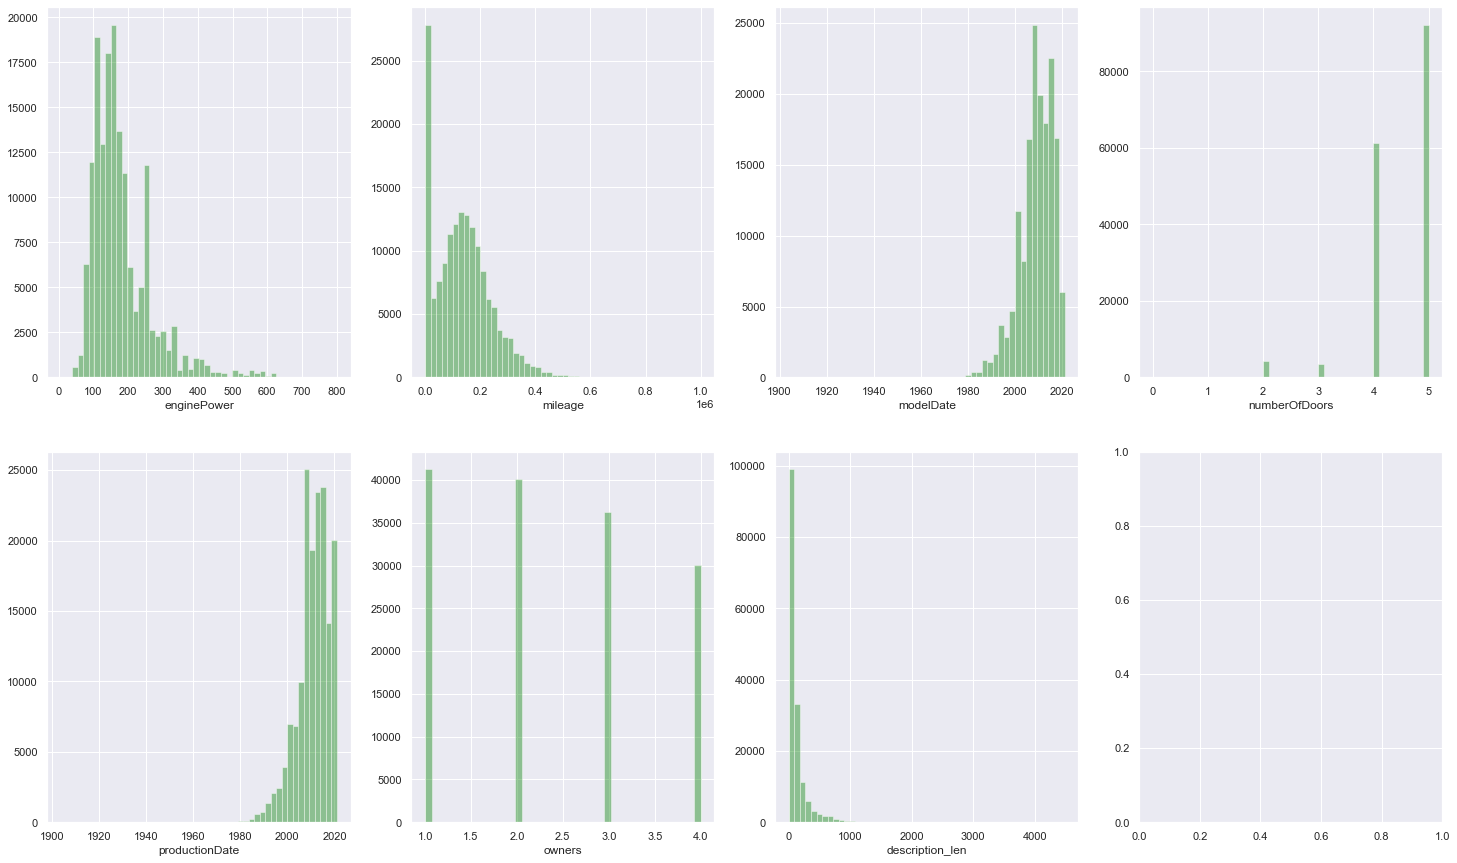

In [427]:
fig, axes = plt.subplots(2, 4, figsize=(25,15))

for i,col in enumerate(df[num_cols]):
    sns.set()
    sns.distplot(df[col], kde=False, ax=axes.flat[i], color="green")

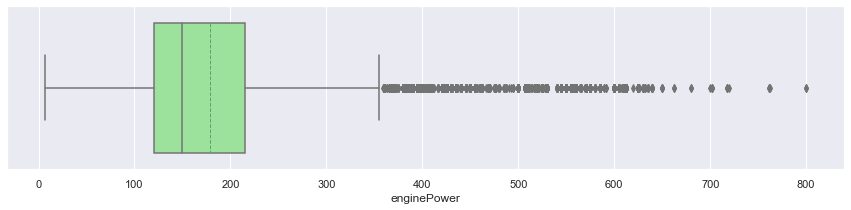

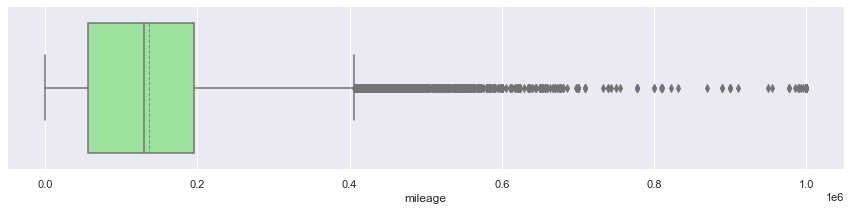

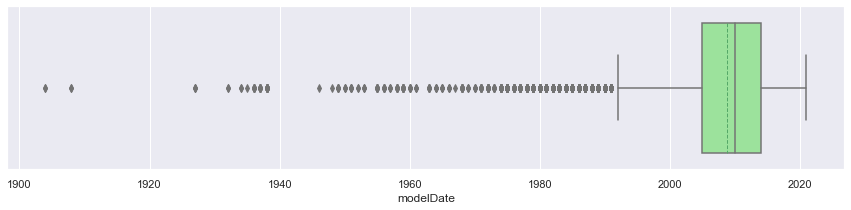

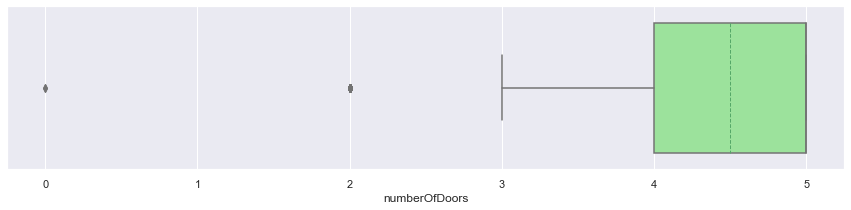

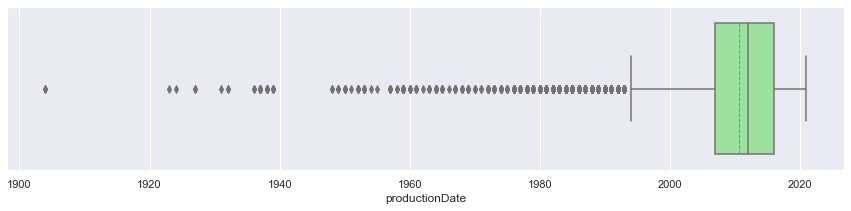

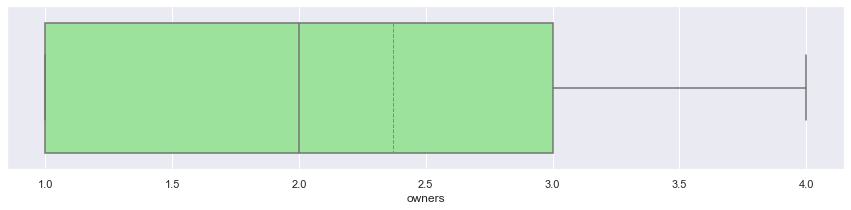

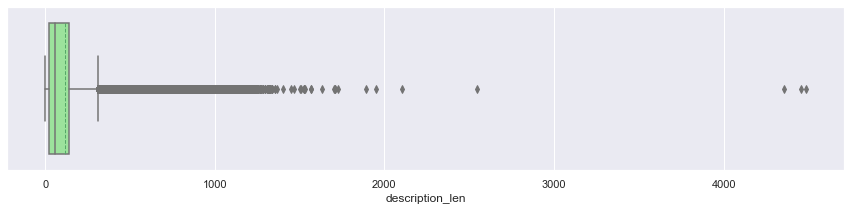

In [428]:
for col in df[num_cols]:
    plt.figure(figsize=(15,3))
    sns.boxplot(x = df[col],showmeans=True, meanline=True, orient='h', color="lightgreen")

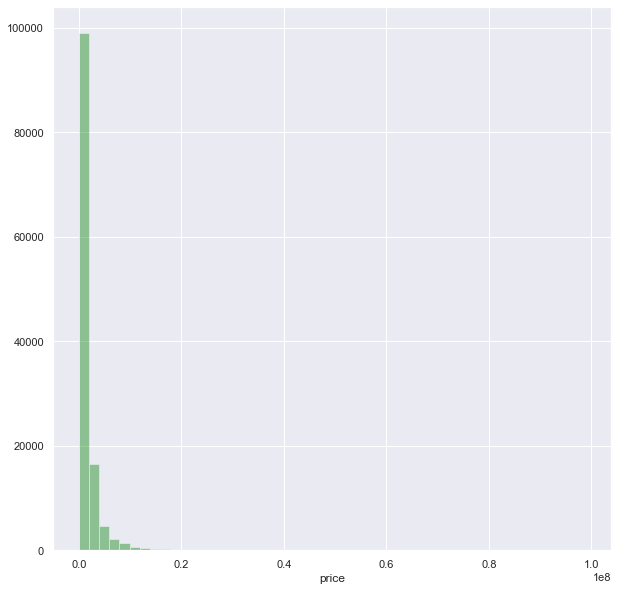

In [429]:
# Распределение целевой переменной
plt.figure(figsize=(10,10))
sns.set()
sns.distplot(df[df["sample"] == 1]["price"], kde=False, color="green")

# Feature Engineering

Добавим несколько новых признаков в наш датасет. Один новый признак у нас уже есть - количество слов в описании.

In [430]:
data = df.copy()

In [431]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,productionDate,vehicleConfiguration,vehicleTransmission,owners,auto_passport,transmission,wheel,price,sample,description_len
0,лифтбек,SKODA,синий,"[все, автомобили, представленные, в, продаже, ...",1.2,105.0,бензин,74000.0,2013.0,OCTAVIA,...,2014,LIFTBACK ROBOT 1.2,роботизированная,4.0,Оригинал,передний,Левый,0.0,0,126
1,лифтбек,SKODA,чёрный,"[лот, автопрага, север, данный, автомобиль, пр...",1.6,110.0,бензин,60563.0,2017.0,OCTAVIA,...,2017,LIFTBACK MECHANICAL 1.6,механическая,1.0,Оригинал,передний,Левый,0.0,0,305
2,лифтбек,SKODA,серый,"[все, автомобили, представленные, в, продаже, ...",1.8,152.0,бензин,88000.0,2013.0,SUPERB,...,2014,LIFTBACK ROBOT 1.8,роботизированная,1.0,Оригинал,передний,Левый,0.0,0,126
3,лифтбек,SKODA,коричневый,"[комплект, зимней, летней, резины, по, сезону,...",1.6,110.0,бензин,95000.0,2013.0,OCTAVIA,...,2014,LIFTBACK AUTOMATIC 1.6,автоматическая,1.0,Оригинал,передний,Левый,0.0,0,208
4,лифтбек,SKODA,белый,"[лот, автопрага, север, вы, можете, получить, ...",1.8,152.0,бензин,58536.0,2008.0,OCTAVIA,...,2012,LIFTBACK AUTOMATIC 1.8,автоматическая,1.0,Оригинал,передний,Левый,0.0,0,277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161240,хэтчбек,HONDA,красный,"[машина, в, отличном, состоянии, есть, что, пе...",1.5,115.0,бензин,373317.0,1999.0,CIVIC,...,1999,HATCHBACK_5_DOORS MECHANICAL 1.5,механическая,4.0,Дубликат,передний,Левый,674938.0,1,24
161241,компактвэн,HONDA,серебристый,"[продам, свою, ласточку, или, поменяю, на, бол...",1.7,130.0,бензин,311000.0,2002.0,STREAM,...,2002,COMPACTVAN AUTOMATIC 1.7,автоматическая,4.0,Оригинал,передний,Правый,1060617.0,1,166
161242,седан,HONDA,серый,"[продаю, личный, автомобиль, технически, испра...",1.8,140.0,бензин,196000.0,2008.0,CIVIC,...,2008,SEDAN MECHANICAL 1.8,механическая,4.0,Дубликат,передний,Левый,1382016.0,1,58
161243,хэтчбек,HONDA,синий,"[в, нормальном, состоянии, требует, внимание, ...",1.4,90.0,бензин,350000.0,2000.0,CIVIC,...,2000,HATCHBACK_5_DOORS MECHANICAL 1.4,механическая,4.0,Дубликат,передний,Левый,433889.0,1,29


In [432]:
# Возраст машины
data['car_years_old'] = 2021 - data.productionDate
data['car_years_old'] = data['car_years_old'].astype(float)
data['car_years_old'].replace([np.inf, -np.inf], 0, inplace=True)

# средний пробег в год
data["mean_mileage_per_year"] = data["mileage"] / data["car_years_old"]
data["mean_mileage_per_year"] = data["mean_mileage_per_year"].astype(float)
data['mean_mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)

# разница в годе выпуска модели и выпуском самого авто
data['diff_product'] = data.productionDate - data.modelDate
data['diff_product'] = data['diff_product'].astype(float)
data['diff_product'].replace([np.inf, -np.inf], 0, inplace=True)

In [433]:
cat_cols = ['bodyType','brand','color','fuelType','vehicleTransmission','transmission','auto_passport','wheel']
num_cols = ['enginePower','mileage','modelDate','numberOfDoors','productionDate','owners','description_len', 'car_years_old',
          "mean_mileage_per_year", 'diff_product']

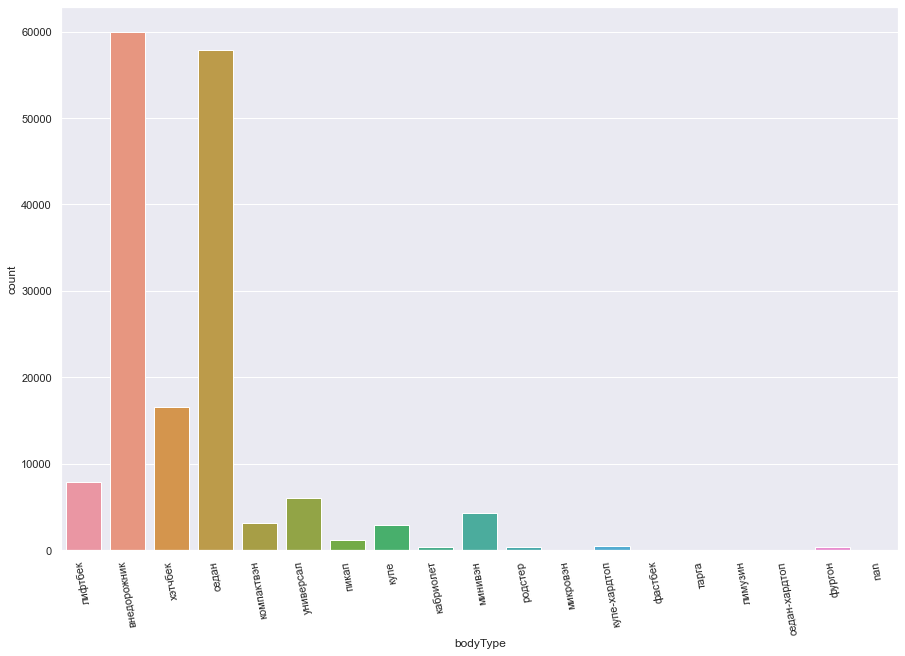

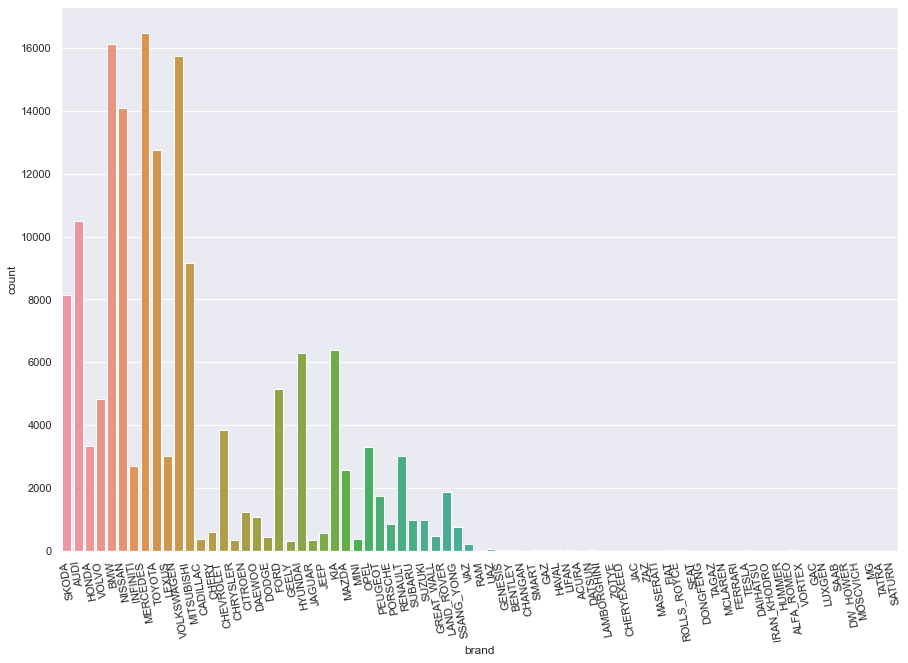

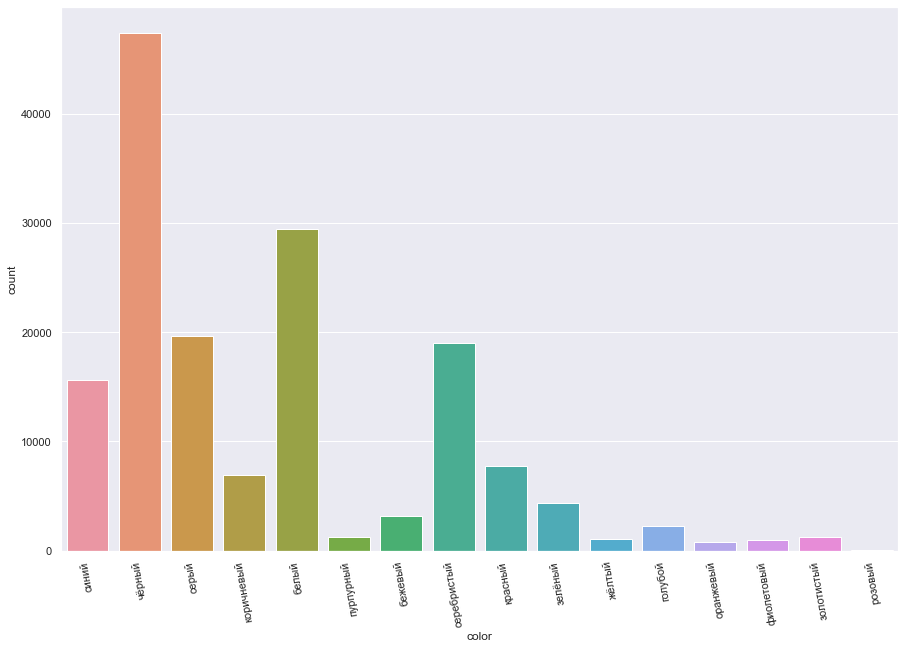

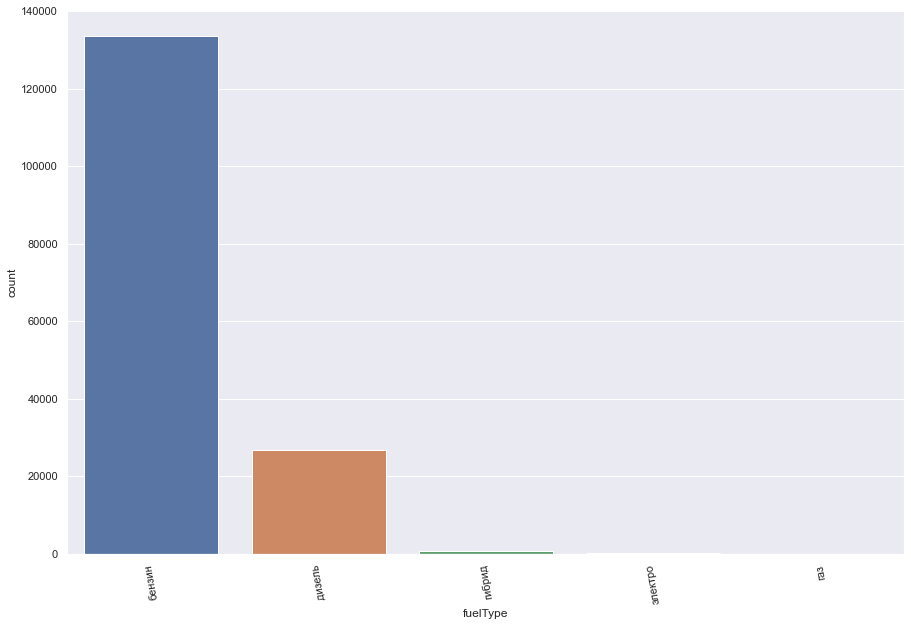

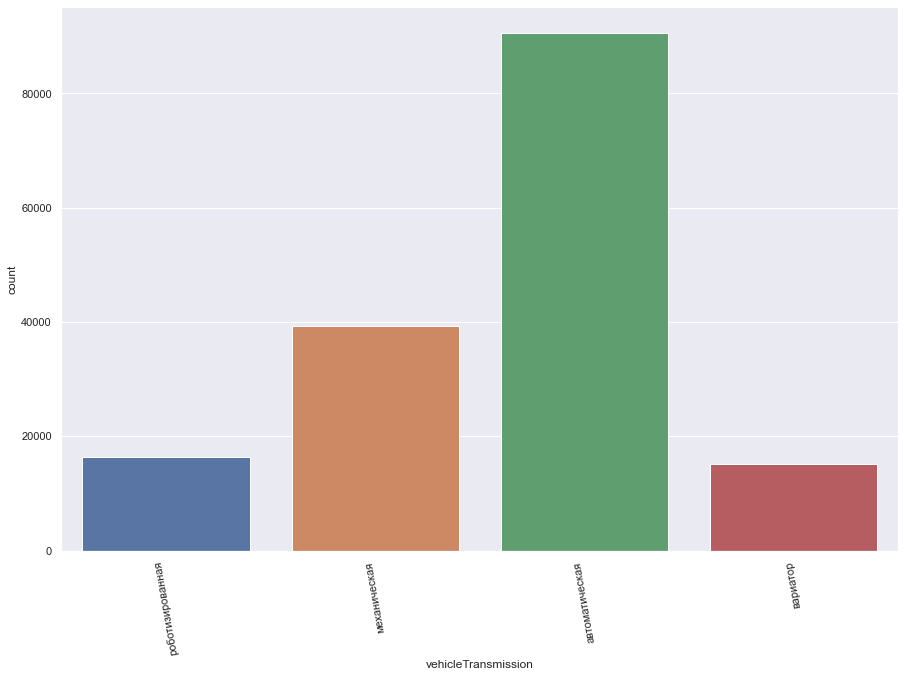

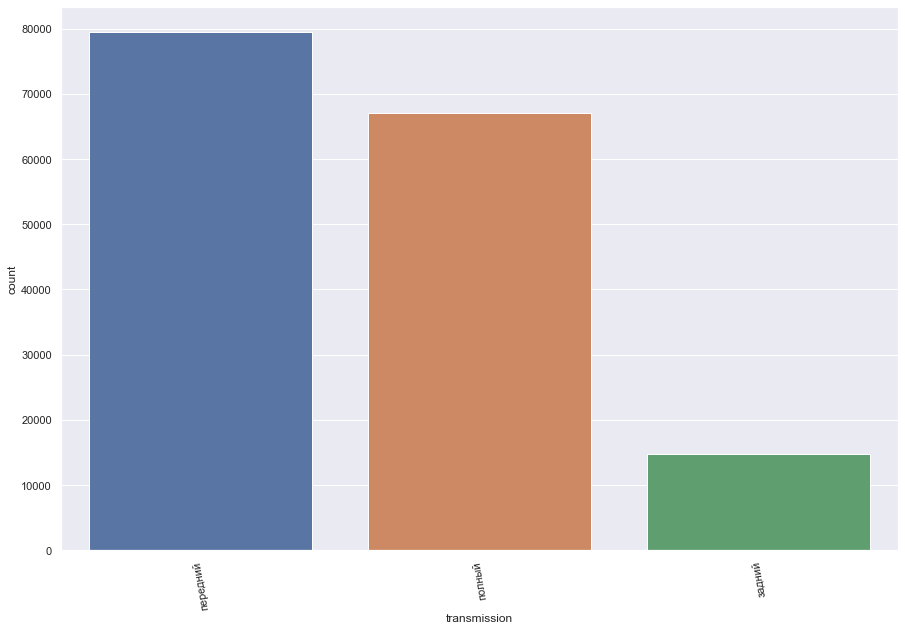

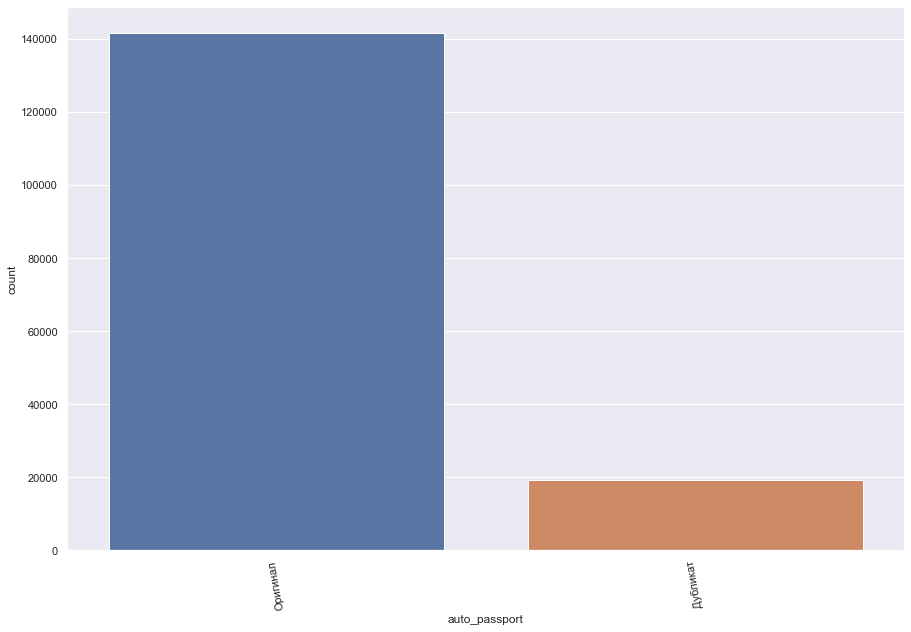

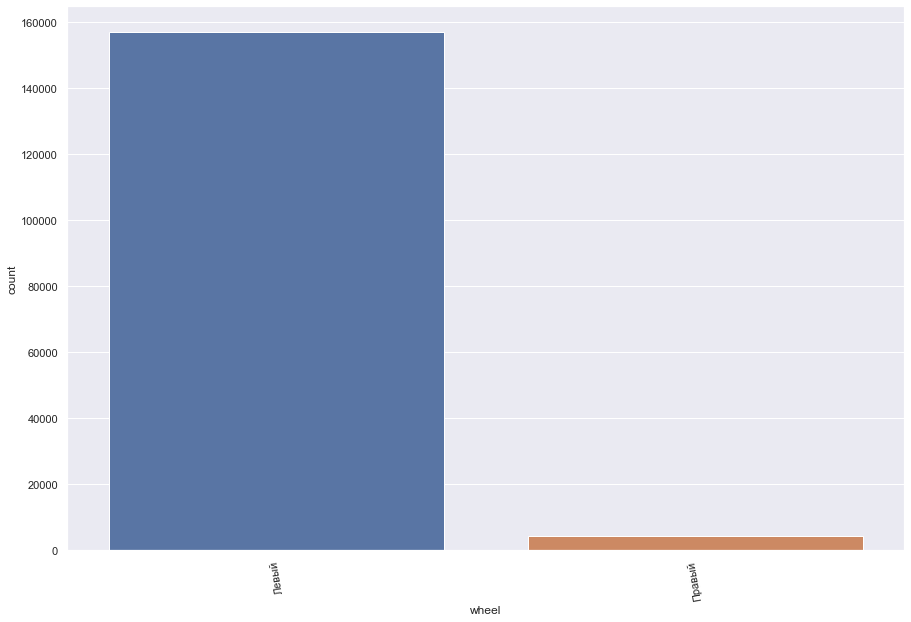

In [434]:

for col in cat_cols:
    plt.figure(figsize=(15,10))
    ax = sns.countplot(x=col, data=data)
    ax.xaxis.set_tick_params(rotation=100)
    plt.show()

## Label encoding

In [435]:
data.head(1)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,...,owners,auto_passport,transmission,wheel,price,sample,description_len,car_years_old,mean_mileage_per_year,diff_product
0,лифтбек,SKODA,синий,"[все, автомобили, представленные, в, продаже, ...",1.2,105.0,бензин,74000.0,2013.0,OCTAVIA,...,4.0,Оригинал,передний,Левый,0.0,0,126,7.0,10571.428571,1.0


In [436]:
all_cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name',
       'vehicleTransmission',  'auto_passport', 'transmission',
       'wheel']

In [437]:
# кодируем наши категориальные переменные
mapped_data = {}
label_encoder = LabelEncoder()
for col in all_cat_cols:
    data[col] = label_encoder.fit_transform(data[col].astype(str))
    mapped_data[col] = dict(enumerate(label_encoder.classes_))

In [438]:
df = data.drop(['description','vehicleConfiguration',], axis=1)

In [439]:
df[df["sample"]==1].dropna()

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_name,numberOfDoors,...,owners,auto_passport,transmission,wheel,price,sample,description_len,car_years_old,mean_mileage_per_year,diff_product
34686,12,2,15,2.8,174.0,0,350000.0,1990.0,1,4.0,...,3.0,2,3,0,200000.0,1,31,30.0,11666.666667,1.0
34687,12,2,7,1.8,90.0,0,173424.0,1982.0,1,4.0,...,3.0,2,2,0,60000.0,1,20,35.0,4954.971429,4.0
34688,15,2,13,2.3,136.0,0,230000.0,1988.0,1,5.0,...,3.0,2,3,0,99000.0,1,130,32.0,7187.500000,1.0
34689,12,2,11,1.8,90.0,0,240000.0,1988.0,1,4.0,...,3.0,2,2,0,65000.0,1,1,32.0,7500.000000,1.0
34690,12,2,15,2.0,101.0,0,300000.0,1990.0,1,4.0,...,3.0,1,2,0,100000.0,1,34,30.0,10000.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161240,18,27,7,1.5,115.0,0,373317.0,1999.0,691,5.0,...,4.0,1,2,0,674938.0,1,24,22.0,16968.954545,0.0
161241,3,27,11,1.7,130.0,0,311000.0,2002.0,2765,5.0,...,4.0,2,2,1,1060617.0,1,166,19.0,16368.421053,0.0
161242,12,27,12,1.8,140.0,0,196000.0,2008.0,691,4.0,...,4.0,1,2,0,1382016.0,1,58,13.0,15076.923077,0.0
161243,18,27,13,1.4,90.0,0,350000.0,2000.0,691,5.0,...,4.0,1,2,0,433889.0,1,29,21.0,16666.666667,0.0


In [440]:
df["engineDisplacement"] = df["engineDisplacement"].astype("float")

In [447]:
dd = df[df["sample"]==1].dropna()

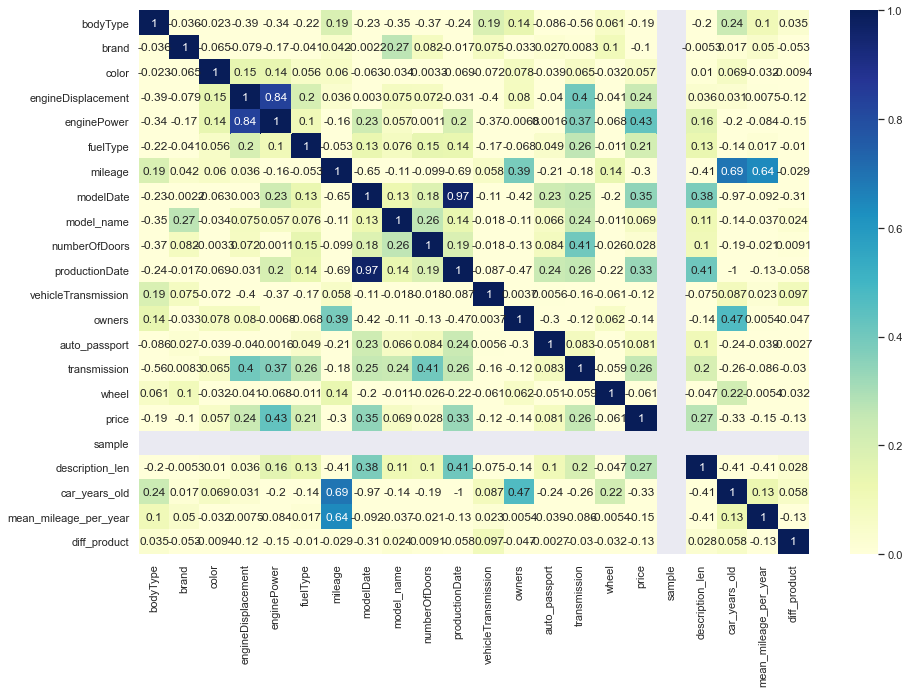

In [442]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(df[df["sample"]==1].corr(), vmin=0, vmax=1, annot = True, cmap="YlGnBu")

Наблюдаем довольно сильную корреляцию между признаками productionDate и modelDate.
Небольшая корреляция видна между переменными transmission и enginePower. Видно, что признак enginePower оказывает влияние на цену автомобиля. Сильно скоррелированы между собой признаки enginePower и engineDisplacement

### Значимость наших признаков:

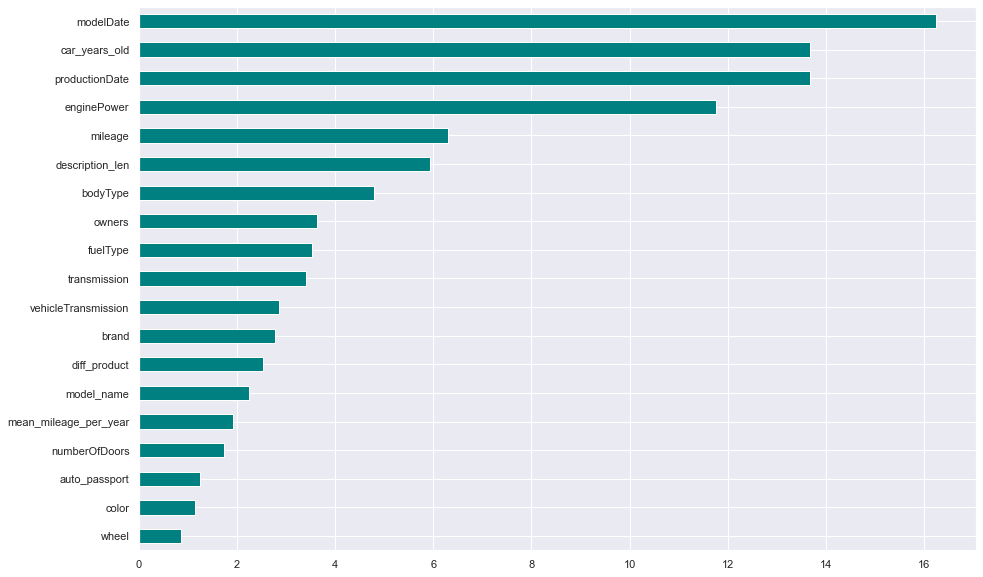

In [448]:
imp_num = pd.Series(f_classif(dd[dd["sample"]==1][all_cat_cols + num_cols], 
                              dd[dd["sample"]==1]['price'])[0], index = all_cat_cols + num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', color="teal")

Наибольшее значение на нашу целевую переменную оказывают следующие признаки:

1) дата выпуска модели (довольно неожиданно)

2) возраст авто

3) год производства

4) мощность двигателя

5) пробег

6) подробность описания

 и так далее

# Split data

In [449]:
train_data = dd.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample','price'], axis=1)
X = train_data.drop(['price'], axis=1)
y = train_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)


# Создадим "наивную" модель
Эта модель будет предсказывать среднюю цену по модели двигателя (engineDisplacement). C ней будем сравнивать другие модели.

In [153]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [154]:
# Находим median по экземплярам engineDisplacement в трейне и размечаем тест
predict = X_test['engineDisplacement'].map(tmp_train.groupby('engineDisplacement')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 83.93%


# Линейная регрессия

In [155]:
linear_regr = LinearRegression().fit(X_train, np.log(y_train+1))
VERSION = 2
predict_test = np.exp(linear_regr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 38.09%


#  CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

In [156]:

model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

#model.save_model('catboost_single_model_baseline.model')

In [157]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 21.83%


### Log Traget
Попробуем взять таргет в логорифм - это позволит уменьшить влияние выбросов на обучение модели (используем для этого np.log и np.exp).    
В принциепе мы можем использовать любое приобразование на целевую переменную. Например деление на курс доллара, евро или гречки :) в дату сбора данных, смотрим дату парсинга в тесте в **parsing_unixtime**

In [158]:
np.log(y_train)

128603    14.375126
139019    12.847927
76028     13.458836
132396    12.072541
149499    14.233563
            ...    
48903     12.409013
109110    12.611538
141042    15.662232
35682     12.676076
59053     14.014361
Name: price, Length: 77604, dtype: float64

In [159]:
VERSION = 3
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

#model.save_model('catboost_single_model_2_baseline.model')

In [160]:
predict_test = np.exp(model.predict(X_test))
predict_submission = np.exp(model.predict(test_data))
VERSION = 4
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_test)) * 100:0.2f}%")

Точность модели по метрике MAPE: 15.26%


##  DecisionTreeRegressor

In [163]:
VERSION = 4 
model_dtr = DecisionTreeRegressor(random_state=RANDOM_SEED)
model_dtr.fit(X_train, np.log(y_train))

predict_test = np.exp(model_dtr.predict(X_test))
m = mape(y_test, predict_test)
print(f"Точность модели по метрике MAPE: {m}%")
#Точность модели по метрике MAPE: 0.2358272835065354%

Точность модели по метрике MAPE: 0.2355933413623385%


##  RandomForestRegressor

In [164]:
VERSION = 5
model_rfr = RandomForestRegressor(150, random_state=RANDOM_SEED, verbose=True)
model_rfr.fit(X_train, np.log(y_train))

predict_test = np.exp(model_rfr.predict(X_test))
m = mape(y_test, predict_test)
print(f"Точность модели по метрике MAPE: {m}%")
# Точность модели по метрике MAPE: 0.1621673229925428%

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  1.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Точность модели по метрике MAPE: 0.16226235646235224%


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.2s finished


## GradientBoosting

In [169]:
# Подбор гиперпараметров 

gb = GradientBoostingRegressor(min_samples_split=2,
                               learning_rate=0.03,
                               max_depth=10,
                               n_estimators=1500)



In [170]:
gb.fit(X_train, np.log(y_train))
predict_test = np.exp(gb.predict(X_test))
m = mape(y_test, predict_test)
print(f"Точность модели по метрике MAPE: {m}%")


Точность модели по метрике MAPE: 0.15196365515344792%


## ExtraTree Regressor

In [182]:
etr = ExtraTreesRegressor(random_state = RANDOM_SEED)
etr.fit(X_train, np.log(y_train))
etr_pred = np.exp(etr.predict(X_test))
print(f"Точность модели по метрике MAPE: {(mape(y_test, etr_pred))*100:0.2f}%")


Точность модели по метрике MAPE: 16.01%


## xgboost

In [193]:
import xgboost as xgb

xb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.03, \
                      max_depth=12, alpha=1, n_jobs=-1, n_estimators=1500)
xb.fit(X_train, np.log(y_train))
print(f"Точность модели по метрике MAPE: {(mape(y_test, np.exp(xb.predict(X_test))))*100:0.2f}%")
predict_test = np.exp(xb.predict(X_test))

Точность модели по метрике MAPE: 14.69%


## Stacking

Объединим в ансамбль CatBoost и Xgboost

In [198]:
estimators = [('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                           colsample_bytree=0.5,
                           learning_rate=0.05,
                           max_depth=12,
                           alpha=1,
                           n_estimators=1500)),
              ('model', CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True))]

st_ensemble = StackingRegressor(estimators=estimators,
                                final_estimator=GradientBoostingRegressor(
                                min_samples_split=2,
                                learning_rate=0.03,
                                max_depth=10,
                                n_estimators=1500))

In [201]:
#st_ensemble.fit(X_train, np.log(y_train))
#predict_ensemble = np.exp(st_ensemble.predict(X_test))
#print(f"Точность модели по метрике MAPE: {(mape(y_test, predict_ensemble))*100:0.2f}%")

# Точность модели по метрике MAPE: 15.57%

К сожалению, лучшего результата достичь не удалось. Лучше всех с задачей справился xgboost, показавший результат в 14.69 %.
Думаю, можно было еще много чего доработать, но времени до делайна оставалось очень мало.


In [ ]:
len(predict_ensemble)

In [451]:
predict_sub = np.exp(xb.predict(test_data))

# Submission

In [452]:
sample_submission['price'] = predict_sub
sample_submission.to_csv(f'submission_2_v{VERSION}.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.414856e+05
1,1100549428,9.265290e+05
2,1100658222,8.296541e+05
3,1100937408,7.614678e+05
4,1101037972,7.355362e+05
5,1100912634,7.683290e+05
6,1101228730,5.802645e+05
7,1100165896,4.022162e+05
8,1100768262,1.785793e+06
9,1101218501,8.128727e+05


# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Спарсить свежие данные 
* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking

Подробный чек лист: https://docs.google.com/spreadsheets/d/1I_ErM3U0Cs7Rs1obyZbIEGtVn-H47pHNCi4xdDgUmXY/edit?usp=sharing